In [1]:
import pandas as pd

file_path = "/content/cumulative_2025.10.04_12.53.39.csv"

with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
    for _ in range(2):
        print(f.readline())


rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_disp_prov,koi_comment,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_time0,koi_time0_err1,koi_time0_err2,koi_eccen,koi_eccen_err1,koi_eccen_err2,koi_longp,koi_longp_err1,koi_longp_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_ingress,koi_ingress_err1,koi_ingress_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_ror,koi_ror_err1,koi_ror_err2,koi_srho,koi_srho_err1,koi_srho_err2,koi_fittype,koi_prad,koi_prad_err1,koi_prad_err2,koi_sma,koi_sma_err1,koi_sma_err2,koi_incl,koi_incl_err1,koi_incl_err2,koi_teq,koi_teq_err1,koi_teq_err2,koi_insol,koi_insol_err1,koi_insol_err2,koi_dor,koi_dor_err1,koi_dor_err2,koi_limbdark_mod,koi_ldm_coeff4,koi_ldm_coeff3,koi_ldm_coeff2,koi_ldm_coeff1,koi_parm_prov,koi_max_sngle_ev,koi_max_mult_ev,koi_

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

file_path = "/content/cumulative_2025.10.04_12.53.39.csv"

# --- Step 1: Detect header line (more flexible) ---
with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
    lines = f.readlines()

header_line = None
for i, line in enumerate(lines):
    cleaned = line.strip().lower().replace('"', '').replace("'", '').lstrip('\ufeff')
    if cleaned.startswith('kepid') or 'kepid' in cleaned.split(','):
        header_line = i
        break

# If still not found, assume first line is header
if header_line is None:
    print("⚠️ Warning: Header not detected automatically. Assuming first line is header.")
    header_line = 0

print(f"✅ Header found at line {header_line}")

# --- Step 2: Load dataset ---
df = pd.read_csv(file_path, skiprows=header_line, low_memory=False)
print("Loaded shape:", df.shape)
print("Columns:", df.columns[:10])

# --- Step 3: Drop irrelevant columns ---
drop_cols = [
    'kepid', 'kepoi_name', 'kepler_name', 'koi_comment',
    'koi_pdisposition', 'koi_disposition_prov', 'koi_tce_delivname'
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

# --- Step 4: Ensure target exists ---
if 'koi_disposition' not in df.columns:
    raise ValueError("Column 'koi_disposition' not found.")

# --- Step 5: Drop rows with missing target ---
df = df.dropna(subset=['koi_disposition'])

# ✅ Keep original class names ---
class_names = df['koi_disposition'].unique().tolist()
print("🎯 Class names:", class_names)

# --- Step 6: Drop columns with >50% missing ---
threshold = len(df) * 0.5
df = df.dropna(thresh=threshold, axis=1)

# --- Step 7: Fill missing values ---
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        df[col] = df[col].fillna(df[col].median())

# --- Step 8: Encode categorical columns (EXCEPT target) ---
for col in df.select_dtypes(include=['object']).columns:
    if col != 'koi_disposition':
        df[col] = pd.factorize(df[col])[0]

# --- Step 9: Split features/labels ---
X = df.drop(columns=['koi_disposition'])
y = df['koi_disposition']

# --- Step 10: Scale features ---
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# --- Step 11: Split train/test ---
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("✅ Data cleaned successfully")
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

# --- Step 12: Save datasets ---
X_train.to_csv("kepler_X_train.csv", index=False)
X_test.to_csv("kepler_X_test.csv", index=False)
y_train.to_csv("kepler_y_train.csv", index=False)
y_test.to_csv("kepler_y_test.csv", index=False)

# --- Step 13: Save class names separately ---
pd.Series(class_names).to_csv("kepler_class_names.csv", index=False)

print("✅ All files saved successfully!")


✅ Header found at line 0
Loaded shape: (9564, 141)
Columns: Index(['rowid', 'kepid', 'kepoi_name', 'kepler_name', 'koi_disposition',
       'koi_vet_stat', 'koi_vet_date', 'koi_pdisposition', 'koi_score',
       'koi_fpflag_nt'],
      dtype='object')
🎯 Class names: ['CONFIRMED', 'CANDIDATE', 'FALSE POSITIVE']
✅ Data cleaned successfully
Train shape: (7651, 115)
Test shape: (1913, 115)
✅ All files saved successfully!


In [5]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# 1️⃣ Load Dataset
X_train = pd.read_csv("kepler_X_train.csv")
X_test = pd.read_csv("kepler_X_test.csv")
y_train = pd.read_csv("kepler_y_train.csv").values.ravel()
y_test = pd.read_csv("kepler_y_test.csv").values.ravel()

# 2️⃣ Encode string labels into numeric classes
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

# 3️⃣ Define all models for comparison
models = {
    "Naive Bayes": GaussianNB(),
    "K Nearest Neighbor": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(),
    "Adaboost": AdaBoostClassifier(n_estimators=100),
    "Neural Network": MLPClassifier(max_iter=300),
    "XGBoost Classifier": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    "Random Forest": RandomForestClassifier(n_estimators=200),
    "LightGBM Classifier": LGBMClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
}

# 4️⃣ Train & Evaluate all models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train_enc)  # استخدام النسخة المرمّزة
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test_enc, y_pred)
    results[name] = acc
    print(f"{name}: {acc:.4f}")

# 5️⃣ Print final accuracy summary
print("\n===== Final Accuracy Results =====")
for model_name, acc in results.items():
    print(f"{model_name}: {acc:.2%}")


Naive Bayes: 0.8751
K Nearest Neighbor: 0.8442
Decision Tree: 0.9090
Adaboost: 0.9226
Neural Network: 0.9195


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:31:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Classifier: 0.9488
Random Forest: 0.9326
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23144
[LightGBM] [Info] Number of data points in the train set: 7651, number of used features: 107
[LightGBM] [Info] Start training from score -1.575515
[LightGBM] [Info] Start training from score -1.247744
[LightGBM] [Info] Start training from score -0.681323
LightGBM Classifier: 0.9493
Gradient Boosting: 0.9462

===== Final Accuracy Results =====
Naive Bayes: 87.51%
K Nearest Neighbor: 84.42%
Decision Tree: 90.90%
Adaboost: 92.26%
Neural Network: 91.95%
XGBoost Classifier: 94.88%
Random Forest: 93.26%
LightGBM Classifier: 94.93%
Gradient Boosting: 94.62%


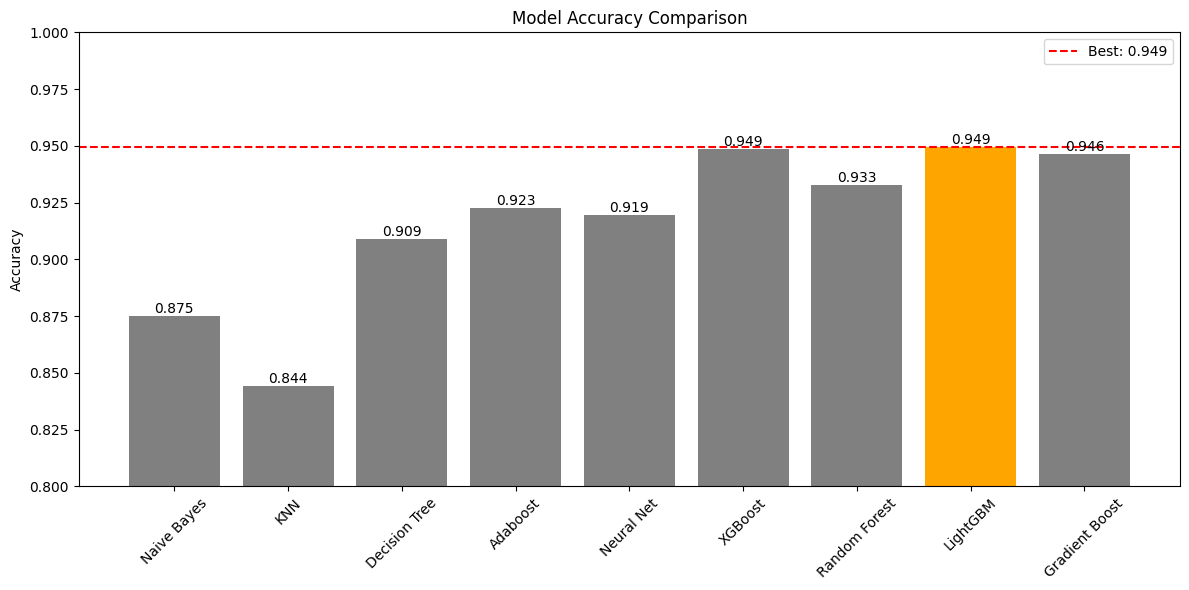

In [7]:
import matplotlib.pyplot as plt

# Model accuracy results
results = {
    "Naive Bayes": 0.8751,
    "KNN": 0.8442,
    "Decision Tree": 0.9090,
    "Adaboost": 0.9226,
    "Neural Net": 0.9195,
    "XGBoost": 0.9488,
    "Random Forest": 0.9326,
    "LightGBM": 0.9493,
    "Gradient Boost": 0.9462
}

# Split keys and values
models = list(results.keys())
accuracies = list(results.values())

# Identify the best model
max_acc = max(accuracies)
max_index = accuracies.index(max_acc)

# Set uniform colors for all bars except the best one
colors = ["gray"] * len(models)
colors[max_index] = "orange"

# Plot the bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(models, accuracies, color=colors)

for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{acc:.3f}",
             ha='center', va='bottom')

plt.axhline(y=max_acc, color='red', linestyle='--', linewidth=1.5, label=f"Best: {max_acc:.3f}")

plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.ylim(0.8, 1.0)
plt.legend()
plt.tight_layout()
plt.show()


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23144
[LightGBM] [Info] Number of data points in the train set: 7651, number of used features: 107
[LightGBM] [Info] Start training from score -1.575515
[LightGBM] [Info] Start training from score -1.247744
[LightGBM] [Info] Start training from score -0.681323
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
✅ LightGBM Accuracy: 0.9488
                precision    recall  f1-score   support

     CANDIDAT

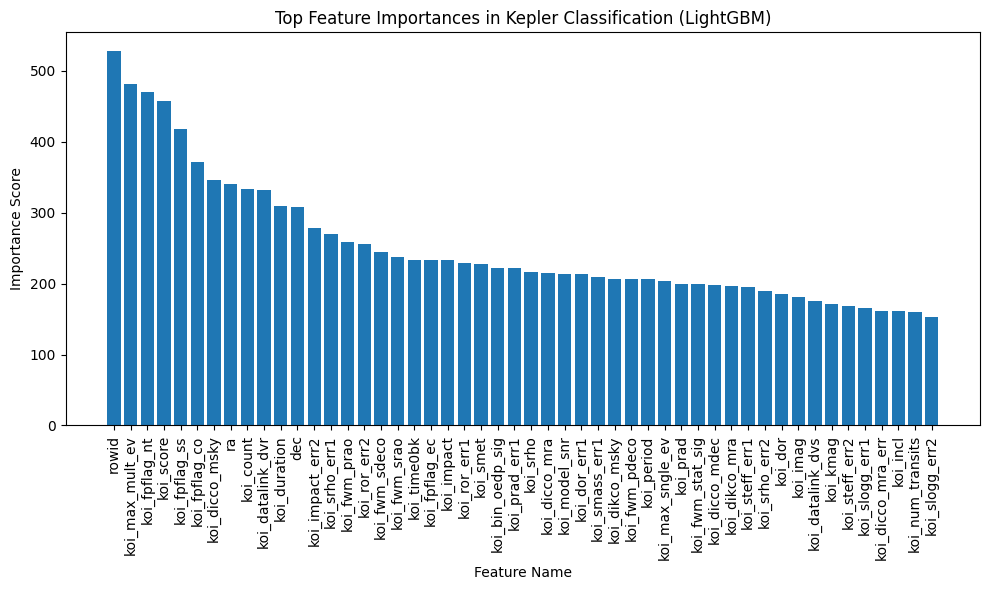

In [31]:
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import numpy as np
from lightgbm import LGBMClassifier

# 1️⃣ Load the preprocessed dataset
X_train = pd.read_csv("kepler_X_train.csv")
X_test = pd.read_csv("kepler_X_test.csv")
y_train = pd.read_csv("kepler_y_train.csv").values.ravel()  # Flatten to 1D array
y_test = pd.read_csv("kepler_y_test.csv").values.ravel()

# 2️⃣ Train the model using LightGBM
model = LGBMClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# 3️⃣ Evaluate the model
y_pred = model.predict(X_test)
print("✅ LightGBM Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print(classification_report(y_test, y_pred))

# 4️⃣ Analyze feature importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort in descending order
top_n = 50  # Display only the top 50 most important features

plt.figure(figsize=(10,6))
plt.title("Top Feature Importances in Kepler Classification (LightGBM)")
plt.bar(range(top_n), importances[indices[:top_n]], align="center")
plt.xticks(range(top_n), X_train.columns[indices[:top_n]], rotation=90)
plt.xlabel("Feature Name")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

In [9]:
import joblib

joblib.dump(model, "lightgbm_kepler_model.pkl")

print("✅ Model saved as lightgbm_kepler_model.pkl")


✅ Model saved as lightgbm_kepler_model.pkl


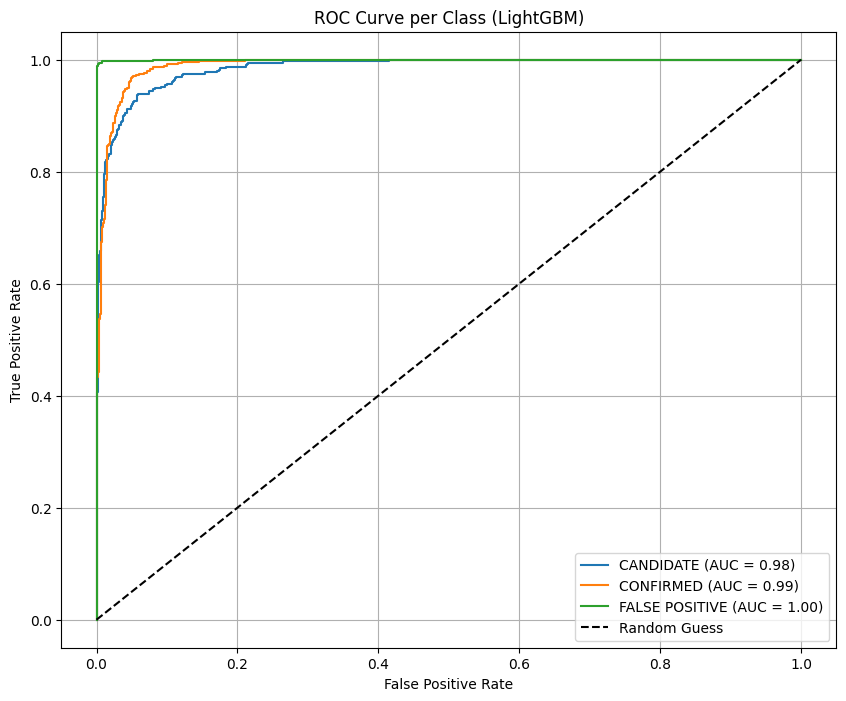

In [10]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# === 1) Binarize the labels for multi-class ROC ===
y_test_bin = label_binarize(y_test_enc, classes=np.arange(len(label_encoder.classes_)))
y_pred_proba = model.predict_proba(X_test)  # ✅ يعمل على LightGBM أو أي موديل يدعم predict_proba

# === 2) Plot ROC for each class ===
plt.figure(figsize=(10, 8))

for i, class_name in enumerate(label_encoder.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")

# === 3) Add Baseline & Labels ===
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.title("ROC Curve per Class (LightGBM)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


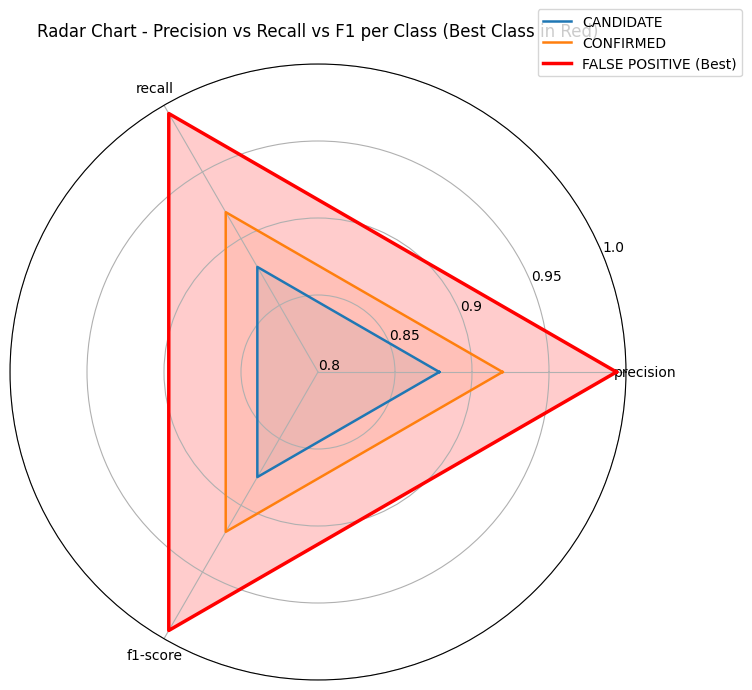

In [32]:
# Extract classification report as a dictionary
report = classification_report(y_test, y_pred, output_dict=True)

# Select only the classes (exclude accuracy/macro/weighted averages)
classes = [cls for cls in report.keys() if cls not in ('accuracy', 'macro avg', 'weighted avg')]
metrics = ['precision', 'recall', 'f1-score']
data = [[report[cls][m] for m in metrics] for cls in classes]

# Identify the best class based on F1-score
f1_scores = [report[cls]['f1-score'] for cls in classes]
best_class_index = int(np.argmax(f1_scores))
best_class = classes[best_class_index]

# Define the angles for the radar chart
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]  # Close the loop

# Create the radar chart
plt.figure(figsize=(8, 8))
ax = plt.subplot(polar=True)

# Set Y-axis range (0.8 to 1.0) for better visibility
ax.set_ylim(0.8, 1.0)
ax.set_yticks([0.8, 0.85, 0.9, 0.95, 1.0])
ax.set_yticklabels(["0.8", "0.85", "0.9", "0.95", "1.0"])

# Plot each class
for i, cls in enumerate(classes):
    values = data[i]
    values += values[:1]  # Close the loop for each class

    if cls == best_class:
        ax.plot(angles, values, linewidth=2.5, color='red', label=f"{cls} (Best)")
        ax.fill(angles, values, color='red', alpha=0.2)
    else:
        ax.plot(angles, values, linewidth=1.8, label=cls)
        ax.fill(angles, values, alpha=0.1)

# Customize plot style
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)
plt.title("Radar Chart - Precision vs Recall vs F1 per Class (Best Class in Red)", pad=20)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.show()


[learning_curve] Training set sizes: [ 765 1912 3060 3825]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   31.8s finished


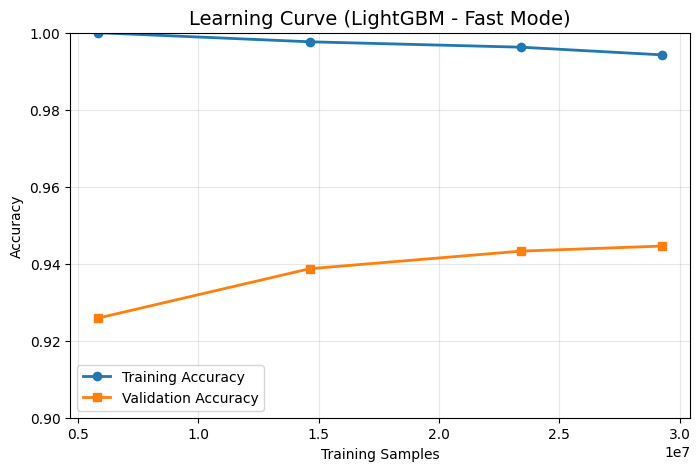

In [33]:
# Ultra-light version of the model
model_lc = LGBMClassifier(
    n_estimators=50,       # Reduced number of estimators
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    random_state=42
)

# Faster Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    model_lc, X_train, y_train_enc,
    cv=2,                                 # Reduced from 3 to 2
    scoring='accuracy',
    train_sizes=[0.2, 0.5, 0.8, 1.0],     # Only 4 points
    n_jobs=-1,
    verbose=1
)

# Compute mean and standard deviation
train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes * len(X_train), train_mean, marker='o', linewidth=2, label="Training Accuracy")
plt.plot(train_sizes * len(X_train), val_mean, marker='s', linewidth=2, label="Validation Accuracy")
plt.title("Learning Curve (LightGBM - Fast Mode)", fontsize=14)
plt.xlabel("Training Samples")
plt.ylabel("Accuracy")
plt.ylim(0.9, 1.0)
plt.grid(alpha=0.3)
plt.legend()
plt.show()


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# === 0) Model Prediction (LightGBM) ===
y_pred = model.predict(X_test)  # Change this if your model name is different

# Ensure y_pred is encoded to match y_test_enc
if isinstance(y_pred[0], str):
    y_pred_enc = label_encoder.transform(y_pred)
else:
    y_pred_enc = y_pred


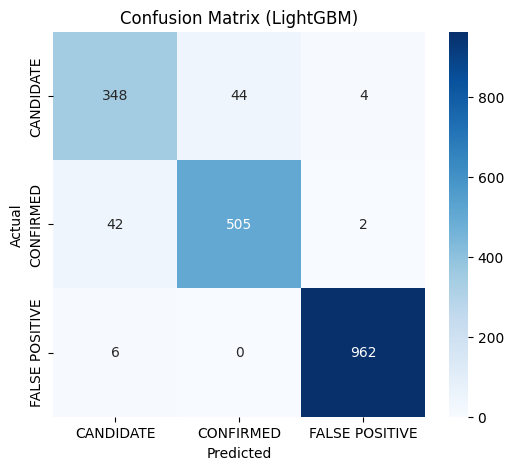

In [28]:
# === 1) Classification Report ===
report = classification_report(y_test_enc, y_pred_enc, output_dict=True)
df_report = pd.DataFrame(report).transpose().iloc[:-3]  # نحذف accuracy/macro/weighted لو مش محتاجينهم

# === 2) Confusion Matrix ===
cm = confusion_matrix(y_test_enc, y_pred_enc, labels=[0,1,2])  # غيّر لو الكلاسات غير 0/1/2

# === 3) Plot Confusion Matrix ===
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix (LightGBM)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

<Figure size 800x500 with 0 Axes>

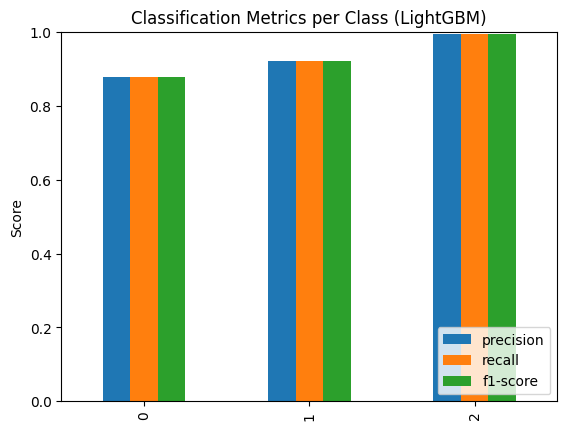

In [29]:
# === 4) Plot Classification Metrics ===
plt.figure(figsize=(8,5))
df_report[['precision', 'recall', 'f1-score']].plot(kind='bar')
plt.title("Classification Metrics per Class (LightGBM)")
plt.ylabel("Score")
plt.ylim(0,1)
plt.legend(loc='lower right')
plt.show()

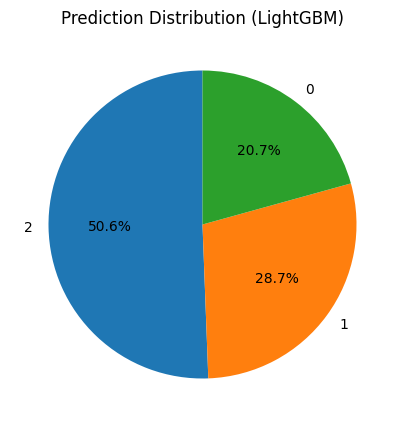

In [30]:
# === 5) Plot Prediction Distribution ===
plt.figure(figsize=(5,5))
pd.Series(y_pred_enc).value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title("Prediction Distribution (LightGBM)")
plt.ylabel("")
plt.show()